<a href="https://colab.research.google.com/github/RohanC07/HealthCare/blob/main/Formative_Data_Analysis_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formative - data analysis task

You have been given access to data on patients attending an opthalmology clinic for cataract surgery.

The data contains pre-, intra- and post-operative data for patients (i.e. data measured before the operation, during the operation, and after the operation).

You are asked to predict those who are discharged from hospital within 24 hours of the operation (`discharge24`), using data available **at the conclusion of the operation**.
    
The folder on the VLE contains three files:
   * `training_data.csv` details of a subset of patients, with `discharge24` disclosed
   * `test_data.csv` details of a subset of patients with `discharge24` not disclosed
   * data_dictionary.gdoc - the data dictionary for these data.
   
You will need to pre-process the training and test datasets. You are asked to include a binary feature that represents whether a patient is overweight or not, based on body mass index (BMI). You should convert this continuous feature into a binary feature, using an appropriate threshold.

You are asked to produce and compare **two** models for the task:
1. a decision tree model
2. a bagged ensemble model

Both models should be optimised your model on the training dataset using the **balanced accuracy score**  

The decision tree model is an interpretable model. Provide some **interpretability** of your bagged ensemble model.

Based on your findings, choose one of your models to select as your final model. Provide a comment explaining your choice.
   
Use your final model to predict the class label (i.e. predict `discharge24`) for those individuals in `test_data.csv`. **Save your predictions as** `y_predict`.

These predictions will be compared to `y_test` (i.e. the actual observed values for `discharge24`), which you do not have access to. The performance of your final model on the test data will contribute to your mark for this question.   

Your code should be commented, and you should also include text sections in your notebook providing additional background information and any references needed to explain your code.

The marking rubric is available here: https://docs.google.com/document/d/1OGZKaPKO61JOtGoPn_XT5bj2mqYksRxtFNg_irU7__g/edit?usp=sharing

When you have finished, download this notebook as an .ipynb format, and upload it to the submission point.

# **(1) Load the Data**

In [3]:
import pandas as pd
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Assesment/Data Science in HealthCare/training_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Assesment/Data Science in HealthCare/test_data.csv")

In [6]:
train_df.head()

,patient_id,male,amd,hist_eye_trauma,glaucoma,myopia,retinal_tear_pre,diabetes,prev_surgery,both_eyes,...,endophthalmitis,retinal_tear_post,wound_leak,age,sats,respiratory_rate,prev_surgery_sr,bmi,lens_subluxation,discharge24
0,61069520,1,0,0.0,0.0,0.0,0,0.0,1.0,0,...,0,1.0,0,80.0,99,17,1,24.400000,NaN,1
1,99423217,1,0,0.0,0.0,NaN,0,0.0,0.0,0,...,0,NaN,0,55.0,97,17,0,22.900000,NaN,1
2,60225409,1,0,0.0,0.0,0.0,0,0.0,0.0,0,...,0,1.0,0,66.0,98,18,0,29.200001,NaN,1
3,97192422,1,1,0.0,1.0,0.0,0,0.0,0.0,0,...,0,1.0,0,60.0,97,18,0,31.299999,NaN,0
4,83176879,0,1,0.0,0.0,NaN,0,0.0,0.0,0,...,0,0.0,0,NaN,95,13,0,28.000000,NaN,1


In [7]:
test_df.head()

,patient_id,male,amd,hist_eye_trauma,glaucoma,myopia,retinal_tear_pre,diabetes,prev_surgery,both_eyes,surgery_type,endophthalmitis,retinal_tear_post,wound_leak,age,sats,respiratory_rate,prev_surgery_sr,bmi,lens_subluxation
0,74687200,1,1,1.0,1.0,NaN,1,0.0,1.0,1,2,0,0.0,0,95.0,100,29,1,22.200001,NaN
1,38937052,1,0,1.0,1.0,0.0,0,1.0,NaN,1,1,0,NaN,0,86.0,100,17,0,20.900000,NaN
2,3167113,0,0,0.0,0.0,NaN,0,0.0,0.0,0,0,0,1.0,0,39.0,96,16,1,21.900000,NaN
3,17210939,1,1,1.0,NaN,1.0,1,1.0,0.0,1,2,0,0.0,0,95.0,101,25,1,26.299999,NaN
4,61006873,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,1.0,0,39.0,97,15,0,18.000000,NaN


## **(2) Preprocessing**

In [8]:
# Define function to convert BMI to binary overweight status
def is_overweight(bmi):
    return 1 if bmi >= 25 else 0

# Apply to both datasets
train_df['is_overweight'] = train_df['bmi'].apply(is_overweight)
test_df['is_overweight'] = test_df['bmi'].apply(is_overweight)

# Optional: Drop the original BMI column
train_df.drop('bmi', axis=1, inplace=True)
test_df.drop('bmi', axis=1, inplace=True)

# **(3) Build and Evaluate Models**

In [12]:
# Imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Separate target and features
y_train = train_df['discharge24']
X_train = train_df.drop(columns=['discharge24'])
X_test = test_df.copy()

# Impute missing values with mean
imputer = SimpleImputer(strategy="mean")
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Split training data for model validation (e.g., 80% train / 20% validation)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_imputed, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 1. Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_split, y_train_split)
y_pred_dt = dt_model.predict(X_val_split)

# Evaluate using balanced accuracy
dt_score = balanced_accuracy_score(y_val_split, y_pred_dt)
print(f"Balanced Accuracy (Decision Tree): {dt_score:.4f}")

# 2. Bagged Ensemble Model (BaggingClassifier with Decision Tree base)
bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
bag_model.fit(X_train_split, y_train_split)
y_pred_bag = bag_model.predict(X_val_split)

# Evaluate Bagged Model
bag_score = balanced_accuracy_score(y_val_split, y_pred_bag)
print(f"Balanced Accuracy (Bagged Ensemble): {bag_score:.4f}")


Balanced Accuracy (Decision Tree): 0.7348
Balanced Accuracy (Bagged Ensemble): 0.8028


# **(4) Train Final Model on Full Training Set**
Bagged Ensemble model has the better accuracy than Decision tree. So, we are choosing Bagged Ensemble as our final model.

In [14]:
# Train final bag_model on full training data
final_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_imputed, y_train)

# Predicting on the test set
y_predict = final_model.predict(X_test_imputed)

# Saving predictions to a CSV
import numpy as np

# Save as y_predict for submission
np.save("y_predict.npy", y_predict)  # This creates a .npy file

# OR if want to export CSV for manual checking:
pd.DataFrame(y_predict, columns=["discharge24"]).to_csv("y_predict.csv", index=False)


# **(5) Interpretability**

In [15]:
# Example: Feature importances (mean across estimators)
import numpy as np

importances = np.mean([
    tree.feature_importances_ for tree in final_model.estimators_
], axis=0)

# Display top features
feature_importance_df = pd.DataFrame({
    "feature": X_train_imputed.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance_df.head(10)

,feature,importance
3,hist_eye_trauma,0.310957
4,glaucoma,0.158306
0,patient_id,0.144200
14,age,0.086448
16,respiratory_rate,0.050381
15,sats,0.047986
7,diabetes,0.034116
6,retinal_tear_pre,0.023202
17,prev_surgery_sr,0.019197
12,retinal_tear_post,0.016391


# **(6) Visualizations**
1. Feature Importance Plot

<ipython-input-16-c2f301db4114>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_features, palette="viridis")


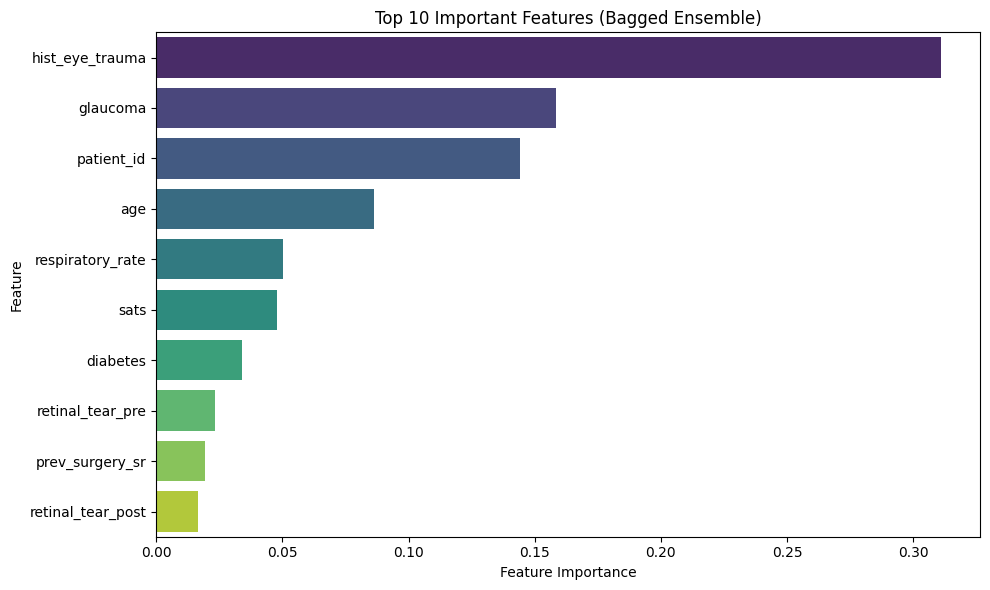

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 10 important features
top_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=top_features, palette="viridis")
plt.title("Top 10 Important Features (Bagged Ensemble)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

2. Confusion Matrix (on validation set)

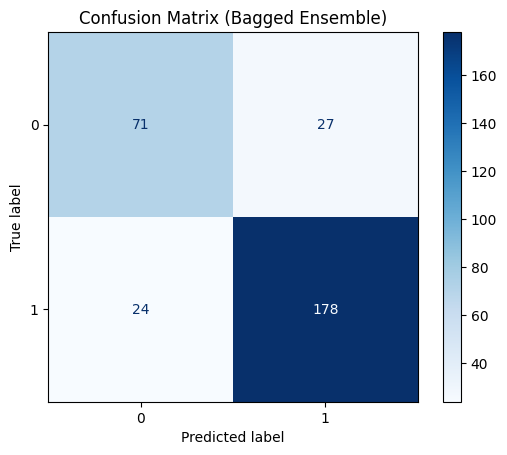

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for bagged model
cm = confusion_matrix(y_val_split, y_pred_bag)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Bagged Ensemble)")
plt.show()

3. Decision Tree Plot

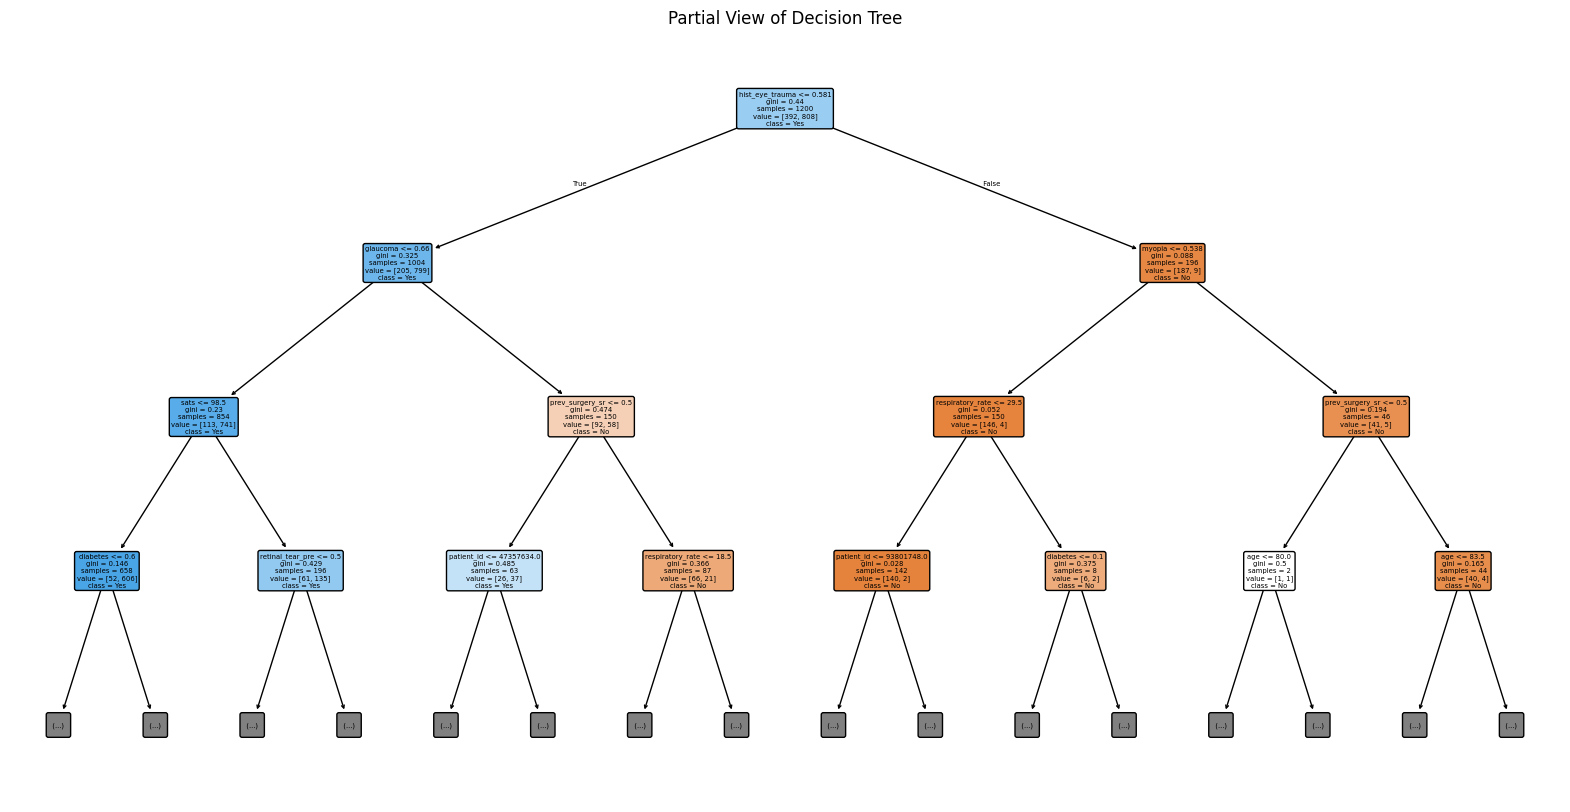

In [18]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, class_names=["No", "Yes"],
          filled=True, rounded=True, max_depth=3)  # adjust max_depth for clarity
plt.title("Partial View of Decision Tree")
plt.show()

4. Distribution of Discharge24 Classes

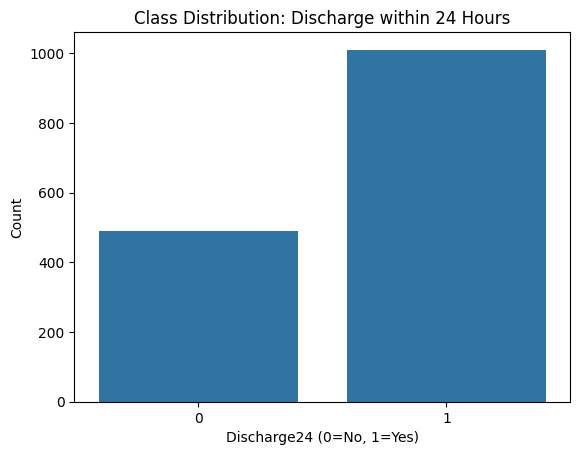

In [19]:
sns.countplot(x=y_train)
plt.title("Class Distribution: Discharge within 24 Hours")
plt.xlabel("Discharge24 (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()

5. Correlation Heatmap

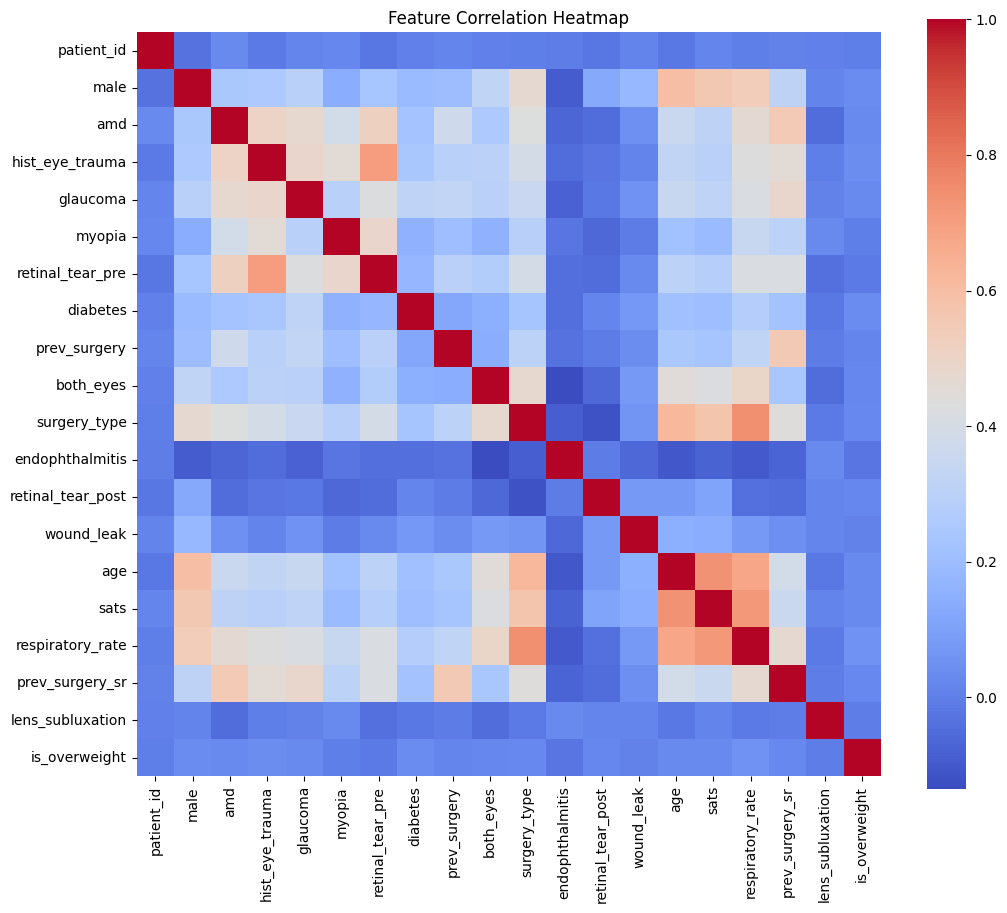

In [20]:
plt.figure(figsize=(12, 10))
corr_matrix = X_train_imputed.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

**You will not be able to run the code below as you do not have access to `y_test`**.

In [ ]:
# do not run this code
y_test = pd.read_csv("y_test.csv")

balanced_accuracy = balanced_accuracy_score(y_true = y_test, y_pred = y_predict)

print(f'Final balanced accuracy: {balanced_accuracy:.6f}')